In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
import stan
import nest_asyncio
from mpl_toolkits.mplot3d import Axes3D
nest_asyncio.apply()
import time

In [22]:
# Parameters
alpha = 6
beta_param = 1.7

mu = 0.4
sigma = 0.1

p = 0.7
seed = 3
N = 1000


def create_data_2d(alpha, beta_param, mu, sigma, p, seed, n=N):
    np.random.seed(seed)
    out_x = []
    out_y = []
    labels = []
    bernoulli = np.random.binomial(1, p, size=n)
    for i in range(len(bernoulli)):
        if bernoulli[i] == 1:
            out_x.append(beta.rvs(alpha, beta_param))
            out_y.append(beta.rvs(alpha, beta_param))
            labels.append('Beta')
        else:
            out_x.append(np.random.normal(mu, sigma))
            out_y.append(np.random.normal(mu, sigma))
            labels.append('Normal')
    return np.array(out_x), np.array(out_y), np.array(labels)

# Create 2D data
data_x, data_y, labels = create_data_2d(alpha, beta_param, mu, sigma, p, seed)

# Map data to the interval [1, m] in 2D
m = 20

data_x_scaled = ((data_x - data_x.min()) / (data_x.max() - data_x.min()) * (m - 1)).astype(int) + 1
data_y_scaled = ((data_y - data_y.min()) / (data_y.max() - data_y.min()) * (m - 1)).astype(int) + 1

data_scaled_2d = np.stack([data_x_scaled, data_y_scaled])
score = np.stack((data_x_scaled, data_y_scaled), axis=1)   #ESTA VARIABLE ES LA QUE VOY A USAR EN EL MODELO
score

array([[18, 16],
       [ 5,  2],
       [18, 15],
       ...,
       [15, 16],
       [11, 19],
       [17, 15]])

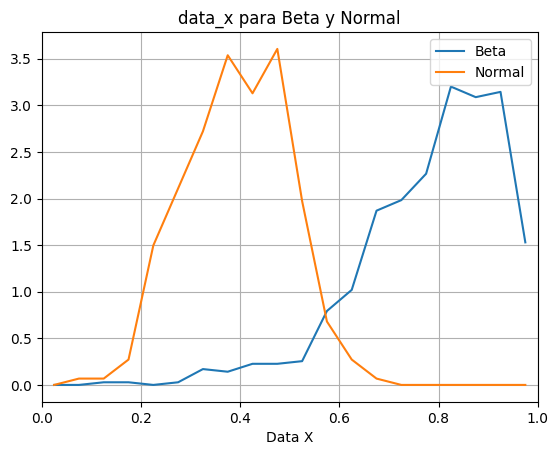

In [23]:
# Crear el histograma normalizado para data_x etiquetada como 'Beta' con 20 bins
counts_beta, bin_edges_beta = np.histogram(data_x[labels == 'Beta'], bins=np.linspace(0,1,m+1), density=True)
bin_centers_beta = (bin_edges_beta[:-1] + bin_edges_beta[1:]) / 2

# Crear el histograma normalizado para data_x etiquetada como 'Normal' con 20 bins
counts_normal, bin_edges_normal = np.histogram(data_x[labels == 'Normal'], bins=np.linspace(0,1,m+1), density=True)
bin_centers_normal = (bin_edges_normal[:-1] + bin_edges_normal[1:]) / 2

# Graficar ambos histogramas normalizados en el mismo gráfico
plt.xlim(0, 1)
plt.plot(bin_centers_beta, counts_beta, linestyle='-', label='Beta')
plt.plot(bin_centers_normal, counts_normal, linestyle='-', label='Normal')
plt.xlabel('Data X')
plt.title('data_x para Beta y Normal')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
len(bin_centers_normal), len(counts_normal)

(20, 20)

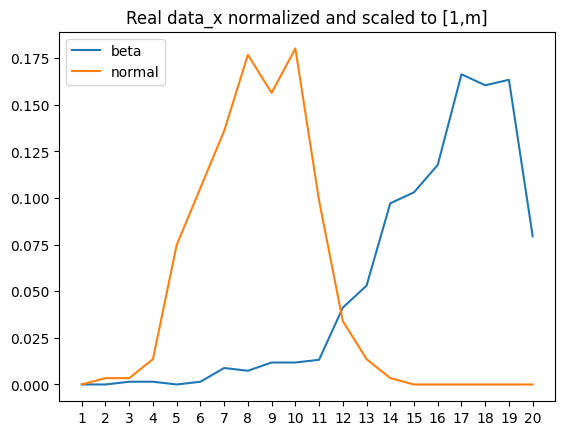

In [5]:
x1 = range(1, 21)
y1 = counts_beta
area=np.trapz(y1,x1)
y1 = y1/area
#print('area1 =',np.trapz(y1,x1),'  m=',len(x1))

x2 = range(1, 21)
y2 = counts_normal
area2=np.trapz(y2,x2)
y2 = y2/area2
#print('area1 =',np.trapz(y2,x2),'  m=',len(x2))

plt.xticks(x1)
#plt.hist(data_x_scaled[labels=='Normal'],density=True)
#plt.hist(data_x_scaled[labels=='Beta'],density=True)
plt.plot(x1,y1,label='beta')
plt.plot(x2,y2,label='normal')
plt.legend()
plt.title('Real data_x normalized and scaled to [1,m]')
plt.show()

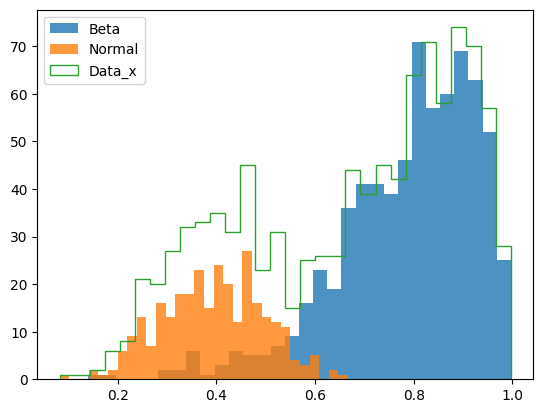

In [6]:
plt.hist(data_x[labels=='Beta'],bins=m+10,density=False,label='Beta',alpha=0.8)
plt.hist(data_x[labels=='Normal'],bins=m+10,density=False,label='Normal',alpha=0.8)
plt.hist(data_x,histtype='step',density=False,alpha=1,bins=m+10,label='Data_x')
plt.legend()
plt.show()

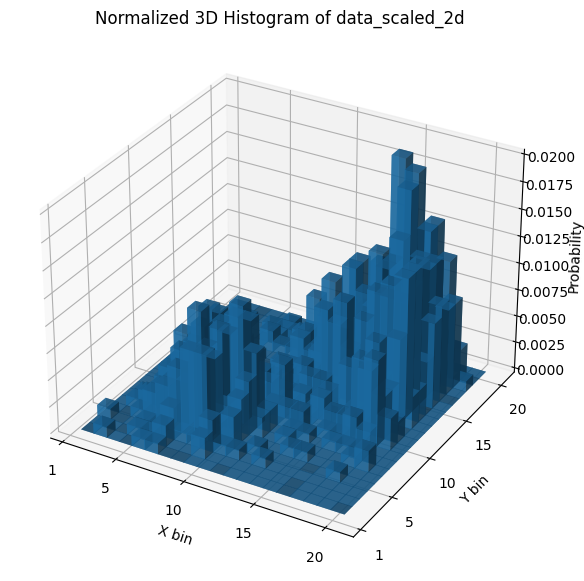

In [7]:
# Create a 2D histogram of the scaled data
hist, xedges, yedges = np.histogram2d(data_x_scaled, data_y_scaled, bins=m)

# Normalize the histogram
total_count = np.sum(hist)
hist_normalized = hist / total_count

# Define the positions of the bin centers
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5, yedges[:-1] + 0.5, indexing="ij")
xpos = xpos.ravel()  # Flatten the array
ypos = ypos.ravel()  # Flatten the array
zpos = np.zeros_like(xpos)  # Start at z=0

# Heights of each bin (normalized)
dz = hist_normalized.ravel()

# Bin size in x and y
dx = dy = np.ones_like(zpos)

# Create the figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D histogram
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', alpha=0.7)

# Set labels and title

ax.set_xticks([1,5,10,15,m])
ax.set_yticks([1,5,10,15,m])
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('X bin')
ax.set_ylabel('Y bin')
ax.set_zlabel('Probability')
ax.set_title('Normalized 3D Histogram of data_scaled_2d')

plt.show()

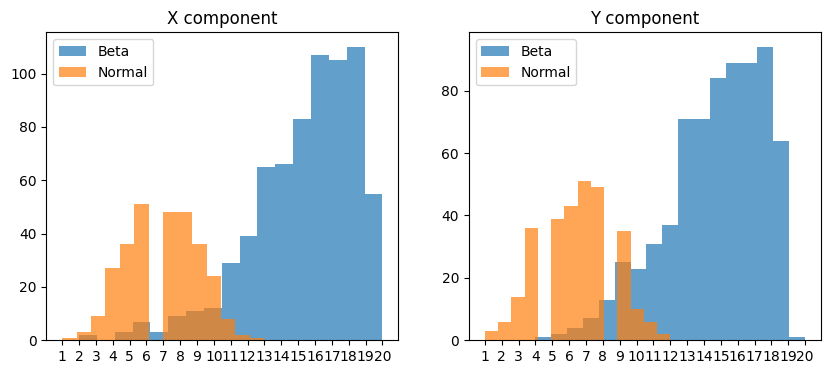

In [8]:
# Filtrar los datos escalados según la etiqueta
x_scaled_beta = data_x_scaled[labels == 'Beta']
x_scaled_normal = data_x_scaled[labels == 'Normal']
y_scaled_beta = data_y_scaled[labels == 'Beta']
y_scaled_normal = data_y_scaled[labels == 'Normal']

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histograma de x - Beta
axes[0].set_title('X component')
axes[0].hist(x_scaled_beta,bins = m-3, alpha=0.7, label='Beta')
axes[0].set_xticks(np.arange(1, m+1))
axes[0].legend()

# Histograma de x - Normal
axes[0].hist(x_scaled_normal, bins = m-6, alpha=0.7, label='Normal')
axes[0].legend()

# Histograma de y - Beta
axes[1].set_title('Y component')
axes[1].hist(y_scaled_beta,bins = m-3, alpha=0.7, label='Beta')
axes[1].set_xticks(np.arange(1, m+1))
axes[1].legend()

# Histograma de y - Normal
axes[1].hist(y_scaled_normal, bins = m-6, alpha=0.7, label='Normal')
axes[1].legend()


In [9]:
my_mixture_2d = """
functions {
  real partial_sum(array[,] int score_slice,
                   int start, int end,
                   vector yj,
                   vector yb,
                   vector theta)
{
    real partial_target = 0;
    vector[2] lp;   //2 clases distintas: fondo jj y señal bb.
    int slice_length = end - start + 1;

    for (k in 1:slice_length) {
      lp[1] = log(yj)[score_slice[k,1]] + log(yj)[score_slice[k,2]];  //esto son los jj
      lp[2] = log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]]; // esto es bb
      partial_target += log_mix(theta, lp);
    }

    return partial_target;
  }
}

data {
  int<lower=1> m;  // steps in the discretization
  int<lower=1> N;  // data points
  array[N,2] int<lower=1, upper=m> score;  // b-tagging score for jet#1
}

parameters {
  simplex[2] theta;  // Mixture coefficients of 2 classes as a simplex
  simplex[m] w_j_mode;  // Dirichlet weights for the background
  vector<lower=0>[m-1] a_j;  // Normal parameters for the background
  simplex[m] w_b_mode;  // Dirichlet weights for the signal
  vector<lower=0>[m-1] a_b;  // Normal parameters for the signal
}

transformed parameters {
  vector[m] p_j;  // Approximate distribution for the background
  vector[m-1] sign_j;  // Signs for combination
  vector[m] logp_j;  // Log-probabilities
  ordered[2] y_label_switch_right; 
  ordered[2] y_label_switch_left;
  
  
  sign_j = rep_vector(-1.0, m-1);
  p_j = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_j[j] = 1.0;
      }
    }
    logp_j[1] = 0.0;
    for (j in 2:m) {
      logp_j[j] = logp_j[j-1] + sign_j[j-1] * a_j[j-1];
    }
    p_j += softmax(logp_j) * w_j_mode[k];
  }

  vector[m] p_b;  // Approximate distribution for the signal
  vector[m-1] sign_b;  // Signs for combination
  vector[m] logp_b;  // Log-probabilities

  sign_b = rep_vector(-1.0, m-1);
  p_b = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_b[j] = 1.0;
      }
    }
    logp_b[1] = 0.0;
    for (j in 2:m) {
      logp_b[j] = logp_b[j-1] + sign_b[j-1] * a_b[j-1];
    }
    p_b += softmax(logp_b) * w_b_mode[k];
  }
  y_label_switch_left[1] = p_b[7];
  y_label_switch_left[2] = p_j[7];
  
  y_label_switch_right[1] = p_j[17];
  y_label_switch_right[2] = p_b[17];
  
  
}

model {
  int grainsize = 1;  // Adjust for parallel performance
  theta ~ dirichlet(rep_vector(1.0, 2));  // Prior for theta with valid values
  a_j ~ normal(0, 0.5);  // Prior for normal parameters
  a_b ~ normal(0, 0.5);  // Prior for normal parameters
  w_b_mode ~ dirichlet(rep_vector(1.0, m));  // Ensure valid Dirichlet parameters
  w_j_mode ~ dirichlet(rep_vector(1.0, m));  // Ensure valid Dirichlet parameters

  target += reduce_sum(partial_sum, score, grainsize, p_j, p_b, theta);
}

"""

In [10]:
# Start the timer
start_time_2d = time.time()

# Build and sample from the 2D mixture model
model_2d = stan.build(my_mixture_2d, data={'m': m, 'N': len(data_x_scaled), 'score':score}, random_seed=33)
fit_2d = model_2d.sample(num_chains=5, num_samples=1000)
df_2d = fit_2d.to_frame()

# Stop the timer
end_time_2d = time.time()

# Calculate the elapsed time
elapsed_time_2d = end_time_2d - start_time_2d

# Print the elapsed time
print(f"Time taken to run the 2D model: {elapsed_time_2d:.2f} seconds")


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_4il790cb/model_jbcrgmuz.stan', line 97, column 12: The
    variable partial_sum may not have been assigned a value before its use.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0215772, but should be greater than the previous element, 0.127398 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  Gradient evaluation took 0.000782 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.82 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_righ

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0459821, but should be greater than the previous element, 0.0971365 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_right is not a valid ordered vector. The element at 2 is 0.00249331, but should be greater than the previous element, 0.0255338 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 41, column 2 to column 34)
warn:Rejecti

Time taken to run the 2D model: 0.59 seconds


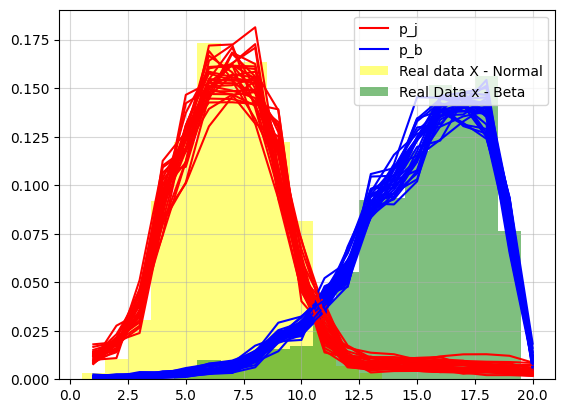

In [11]:
#Normalizing and plotting inferred distributions
for i in range(30):
    # Extract the p_j and p_b values for the current sample
    p_j_values = np.array([df_2d.iloc[i]['p_j.' + str(x)] for x in range(1, 21)])
    p_b_values = np.array([df_2d.iloc[i]['p_b.' + str(x)] for x in range(1, 21)])
    
    # Normalize the values
    p_j_values_normalized = p_j_values / p_j_values.sum()
    p_b_values_normalized = p_b_values / p_b_values.sum()
    
    # Plot the normalized curves
    if i == 0:
        plt.plot(range(1, 21), p_j_values_normalized, color='red', label='p_j')
        plt.plot(range(1, 21), p_b_values_normalized, color='blue', label='p_b')
    else:
        plt.plot(range(1, 21), p_j_values_normalized, color='red')
        plt.plot(range(1, 21), p_b_values_normalized, color='blue')

# Plot histograms for the real data X component
plt.hist(data_x_scaled[labels=='Normal'], bins=np.arange(1, m+1)-0.5, density=True, alpha=0.5, color='yellow', label='Real data X - Normal')
plt.hist(data_x_scaled[labels=='Beta'], bins=np.arange(1, m+1)-0.5, density=True, alpha=0.5, color='green', label='Real Data x - Beta')

#plt.plot(x1[:-1],y1[1:],ls='--',color='black')
#plt.plot(x2[:-1],y2[1:],ls='--',color='black')

plt.legend()
plt.grid(alpha=0.5)
plt.show()


theta_1 = 0.319 +- 0.0168
theta_2 = 0.681 +- 0.0168


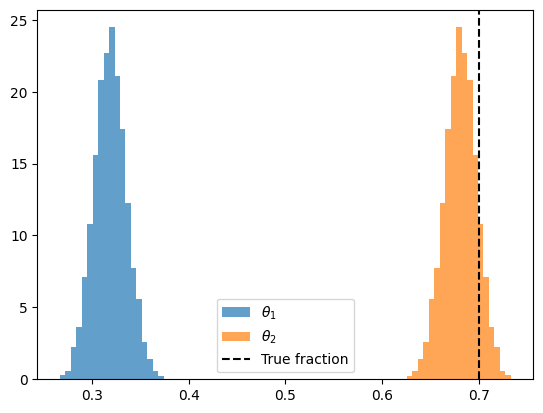

In [12]:
# Plot the posterior distribution of theta.1 and theta.2
plt.hist(df_2d['theta.1'], bins=20, label=r'$\theta_1$', density=True, alpha=0.7)
plt.hist(df_2d['theta.2'], bins=20, label=r'$\theta_2$', density=True, alpha=0.7)
plt.axvline(p, ls='--', color='black', label='True fraction')
plt.legend()
print('theta_1 =', round(np.mean(df_2d['theta.1']), 4), '+-', round(np.std(df_2d['theta.1']), 4))
print('theta_2 =', round(np.mean(df_2d['theta.2']), 4), '+-', round(np.std(df_2d['theta.2']), 4))
plt.show()

In [92]:
def create_data_2d_with_condition(alpha, beta_param, mu, sigma, p, seed, n=N, threshold=0.37):
    np.random.seed(seed)
    out_x = []
    out_y = []
    labels = []
    
    # Continuar generando datos hasta alcanzar la cantidad deseada que cumplan la condición
    while len(out_x) < n:
        bernoulli = np.random.binomial(1, p)
        if bernoulli == 1:
            x = beta.rvs(alpha, beta_param)
            y = beta.rvs(alpha, beta_param)
            label = 'Beta'
        else:
            x = np.random.normal(mu, sigma)
            y = np.random.normal(mu, sigma)
            label = 'Normal'

        # Aplicar la condición de eliminación de datos menores a threshold
        if x >= threshold and y >= threshold:
            out_x.append(x)
            out_y.append(y)
            labels.append(label)
    
    return np.array(out_x), np.array(out_y), np.array(labels)

# Crear los datos 2D con la nueva función y condición
data_x_2, data_y_2, labels_2 = create_data_2d_with_condition(alpha, beta_param, mu, sigma, p, seed)

# Mapear los datos al intervalo [1, m] en 2D
m = 20
data_x_2_scaled = ((data_x_2 - data_x_2.min()) / (data_x_2.max() - data_x_2.min()) * (m - 1)).astype(int) + 1
data_y_2_scaled = ((data_y_2 - data_y_2.min()) / (data_y_2.max() - data_y_2.min()) * (m - 1)).astype(int) + 1

score2 = np.stack((data_x_2_scaled, data_y_2_scaled), axis=1)  # ESTO ES LO QUE SE USA EN EL MODELO
score2

array([[ 6, 13],
       [ 9, 18],
       [18,  9],
       ...,
       [ 4,  2],
       [16, 15],
       [ 1,  2]])

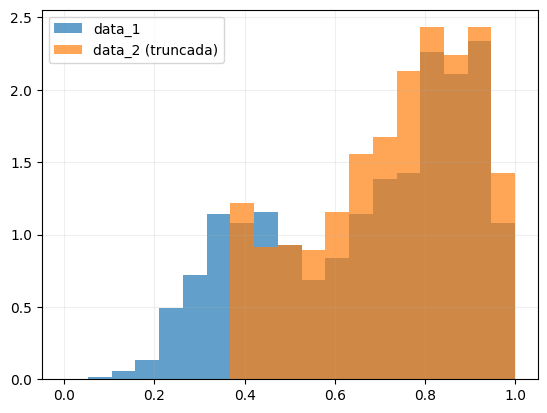

In [93]:
#plt.hist(data_x,bins=np.linspace(0,1,20),alpha=0.7)
plt.hist(data_x,bins=np.linspace(0,1,20),alpha=0.7,density=True,label='data_1')
plt.hist(data_x_2,bins=np.linspace(0,1,20),alpha=0.7,density=True, label='data_2 (truncada)')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

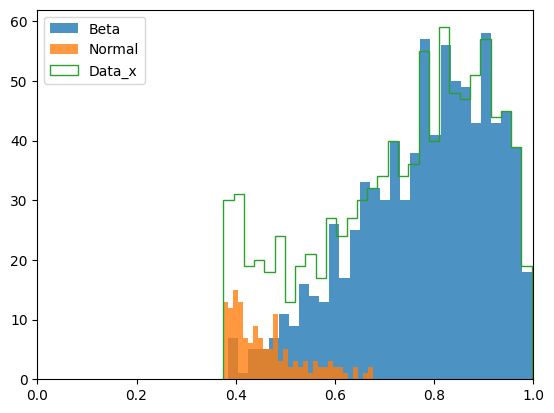

In [94]:
plt.hist(data_x_2[labels_2=='Beta'],bins=m+10,density=False,label='Beta',alpha=0.8)
plt.hist(data_x_2[labels_2=='Normal'],bins=m+10,density=False,label='Normal',alpha=0.8)
plt.hist(data_x_2,histtype='step',density=False,alpha=1,bins=m+10,label='Data_x')
plt.legend()
plt.xlim(0,1)
plt.show()

In [95]:
# Start the timer
start_time_2d = time.time()

# Build and sample from the 2D mixture model
model_2d = stan.build(my_mixture_2d, data={'m': m, 'N': len(data_x_scaled), 'score':score2}, random_seed=33)
fit_2d = model_2d.sample(num_chains=5, num_samples=1000)
df_2d = fit_2d.to_frame()

# Stop the timer
end_time_2d = time.time()

# Calculate the elapsed time
elapsed_time_2d = end_time_2d - start_time_2d

# Print the elapsed time
print(f"Time taken to run the 2D model: {elapsed_time_2d:.2f} seconds")


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_4il790cb/model_jbcrgmuz.stan', line 97, column 12: The
    variable partial_sum may not have been assigned a value before its use.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   0% (5/10000)
Sampling:   1% (104/10000)
Sampling:   2% (203/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  23% (2300/10000)
Sampling:  24% 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0329669, but should be greater than the previous element, 0.0367393 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335886, but should be greater than the previous element, 0.0386828 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0347333, but should be greater than the previous element, 0.0369762 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0318166, but should be greater than the previous element, 0.0323211 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0318415, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310185, but should be greater than the previous element, 0.0321931 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0297968, but should be greater than the previous element, 0.0320208 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0302887, but should be greater than the previous element, 0.0311173 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0313237, but should be greater than the previous element, 0.0323818 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0270806, but should be greater than the previous element, 0.0294446 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0285285, but should be greater than the previous element, 0.0287955 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0291784, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0306818, but should be greater than the previous element, 0.0308561 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.031001, but should be greater than the previous element, 0.0311384 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0277127, but should be greater than the previous element, 0.0334353 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0337533, but should be greater than the previous element, 0.0338579 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0284486, but should be greater than the previous element, 0.0303937 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0300868, but should be greater than the previous element, 0.0308069 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0267735, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.036371, but should be greater than the previous element, 0.0401839 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0343141, but should be greater than the previous element, 0.0384898 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0289335, but should be greater than the previous element, 0.029614 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305257, but should be greater than the previous element, 0.0310846 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0265968, but should be greater than the previous element, 0.0298124 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0311123, but should be greater than the previous element, 0.032539 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0279551, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0290867, but should be greater than the previous element, 0.0300641 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0275148, but should be greater than the previous element, 0.0291201 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0345052, but should be greater than the previous element, 0.0347752 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.023318, but should be greater than the previous element, 0.0303844 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.030825, but should be greater than the previous element, 0.0314237 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mo

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0283312, but should be greater than the previous element, 0.0308058 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0264487, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0244767, but should be greater than the previous element, 0.0246693 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0320067, but should be greater than the previous element, 0.0344824 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0359682, but should be greater than the previous element, 0.0378387 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0341277, but should be greater than the previous element, 0.0341363 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0296847, but should be greater than the previous element, 0.029906 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mo

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0363984, but should be greater than the previous element, 0.0369661 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0383336, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0302942, but should be greater than the previous element, 0.0309312 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0327637, but should be greater than the previous element, 0.0343834 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0356556, but should be greater than the previous element, 0.0357233 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0372612, but should be greater than the previous element, 0.0382456 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0281316, but should be greater than the previous element, 0.0300991 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0318912, but should be greater than the previous element, 0.0352153 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0315264, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0291025, but should be greater than the previous element, 0.0299101 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0290887, but should be greater than the previous element, 0.029119 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.030215, but should be greater than the previous element, 0.0323886 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0318515, but should be greater than the previous element, 0.032615 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0300385, but should be greater than the previous element, 0.0310607 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0294671, but should be greater than the previous element, 0.0295274 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0271224, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0337214, but should be greater than the previous element, 0.0361251 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0324682, but should be greater than the previous element, 0.0340165 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0342341, but should be greater than the previous element, 0.0347523 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0265204, but should be greater than the previous element, 0.0279506 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0306108, but should be greater than the previous element, 0.0318262 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305147, but should be greater than the previous element, 0.030702 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325233, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0288248, but should be greater than the previous element, 0.0297301 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0270038, but should be greater than the previous element, 0.0274104 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.033445, but should be greater than the previous element, 0.0341815 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0297599, but should be greater than the previous element, 0.0310697 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0351076, but should be greater than the previous element, 0.0374297 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0276788, but should be greater than the previous element, 0.0295019 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0359994, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0392105, but should be greater than the previous element, 0.0399218 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0259664, but should be greater than the previous element, 0.0300006 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0360307, but should be greater than the previous element, 0.0366707 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0308721, but should be greater than the previous element, 0.0331402 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0270708, but should be greater than the previous element, 0.0271737 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0287418, but should be greater than the previous element, 0.031671 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028252, but should be greater 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0272771, but should be greater than the previous element, 0.0317344 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0313879, but should be greater than the previous element, 0.0316209 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305664, but should be greater than the previous element, 0.0308844 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0309258, but should be greater than the previous element, 0.0317196 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0291029, but should be greater than the previous element, 0.0297695 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.029186, but should be greater than the previous element, 0.0294977 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0281405, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0268926, but should be greater than the previous element, 0.0298901 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0247842, but should be greater than the previous element, 0.0321215 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0299001, but should be greater than the previous element, 0.0318103 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0334489, but should be greater than the previous element, 0.0342074 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0286425, but should be greater than the previous element, 0.0290306 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0279358, but should be greater than the previous element, 0.0285947 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.029567, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0241678, but should be greater than the previous element, 0.0290203 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028752, but should be greater than the previous element, 0.0332381 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0267213, but should be greater than the previous element, 0.0285877 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0224067, but should be greater than the previous element, 0.0252805 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0292862, but should be greater than the previous element, 0.0338743 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028956, but should be greater than the previous element, 0.0292542 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0345147, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0350127, but should be greater than the previous element, 0.0368747 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0314331, but should be greater than the previous element, 0.0320402 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0291056, but should be greater than the previous element, 0.0298942 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_pro

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.035428, but should be greater than the previous element, 0.0375172 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0316494, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0348695, but should be greater than the previous element, 0.0352271 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0314496, but should be greater than the previous element, 0.0326997 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.034718, but should be greater than the previous element, 0.0360494 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0348059, but should be greater than the previous element, 0.03659 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0353495, but should be greater than the previous element, 0.0359574 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0291074, but should be greater than the previous element, 0.0291218 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0307029, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0298014, but should be greater than the previous element, 0.03228 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.029209, but should be greater than the previous element, 0.0307455 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0351709, but should be greater than the previous element, 0.0355246 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0282952, but should be greater than the previous element, 0.0315394 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0324587, but should be greater than the previous element, 0.0332815 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.031558, but should be greater than the previous element, 0.0325103 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0303853, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0303665, but should be greater than the previous element, 0.0317043 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0324243, but should be greater than the previous element, 0.0331641 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0293464, but should be greater than the previous element, 0.0325359 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0303513, but should be greater than the previous element, 0.0308103 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0385913, but should be greater than the previous element, 0.0387726 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0301044, but should be greater than the previous element, 0.0306597 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0273908, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0316104, but should be greater than the previous element, 0.0317386 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0382911, but should be greater than the previous element, 0.0393368 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0329679, but should be greater than the previous element, 0.0341751 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0241827, but should be greater than the previous element, 0.0265941 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0286345, but should be greater than the previous element, 0.0291734 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0330529, but should be greater than the previous element, 0.0339862 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0297828, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0358786, but should be greater than the previous element, 0.0366213 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335172, but should be greater than the previous element, 0.0337914 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0284399, but should be greater than the previous element, 0.0286283 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0317882, but should be greater than the previous element, 0.0325861 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0320299, but should be greater than the previous element, 0.0327642 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0279682, but should be greater than the previous element, 0.028489 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0288648, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0263109, but should be greater than the previous element, 0.026328 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0234042, but should be greater than the previous element, 0.0251795 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0352366, but should be greater than the previous element, 0.037721 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0254985, but should be greater than the previous element, 0.0305952 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0317161, but should be greater than the previous element, 0.0318253 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0394934, but should be greater than the previous element, 0.0397269 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0343292, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0341702, but should be greater than the previous element, 0.0347603 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0292591, but should be greater than the previous element, 0.0304079 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310415, but should be greater than the previous element, 0.0311299 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0339881, but should be greater than the previous element, 0.034048 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0312017, but should be greater than the previous element, 0.0318217 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0294904, but should be greater than the previous element, 0.0296272 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0319688, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0313927, but should be greater than the previous element, 0.0320323 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0351891, but should be greater than the previous element, 0.0356144 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0290532, but should be greater than the previous element, 0.0313961 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0298631, but should be greater than the previous element, 0.0306352 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.02911, but should be greater than the previous element, 0.0317873 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mod

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335584, but should be greater than the previous element, 0.033822 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0319435, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0376276, but should be greater than the previous element, 0.0388846 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0298607, but should be greater than the previous element, 0.0306374 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.030196, but should be greater than the previous element, 0.0304431 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0330562, but should be greater than the previous element, 0.0354698 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0270671, but should be greater than the previous element, 0.0279972 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0316585, but should be greater than the previous element, 0.034738 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0316868, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0259245, but should be greater than the previous element, 0.0278489 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0360824, but should be greater than the previous element, 0.0362751 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0327248, but should be greater than the previous element, 0.0328181 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0318685, but should be greater than the previous element, 0.0320486 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0296024, but should be greater than the previous element, 0.0296456 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0294573, but should be greater than the previous element, 0.0300561 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0297235, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0311214, but should be greater than the previous element, 0.0313027 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028262, but should be greater than the previous element, 0.0292018 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305128, but should be greater than the previous element, 0.0344504 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0290704, but should be greater than the previous element, 0.0333564 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0291808, but should be greater than the previous element, 0.0307801 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0255534, but should be greater than the previous element, 0.0269665 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0255409, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0287459, but should be greater than the previous element, 0.0364274 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0271831, but should be greater than the previous element, 0.0289917 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0371966, but should be greater than the previous element, 0.0378109 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0328386, but should be greater than the previous element, 0.0335811 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0299662, but should be greater than the previous element, 0.0339368 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0327928, but should be greater than the previous element, 0.033248 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0293591, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028781, but should be greater than the previous element, 0.0324515 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0346369, but should be greater than the previous element, 0.0353067 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0344263, but should be greater than the previous element, 0.0355363 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0342117, but should be greater than the previous element, 0.0346019 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0345671, but should be greater than the previous element, 0.0349182 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0312562, but should be greater than the previous element, 0.0328462 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0287434, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0357793, but should be greater than the previous element, 0.0365913 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0319915, but should be greater than the previous element, 0.0321445 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0279549, but should be greater than the previous element, 0.0294061 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0283993, but should be greater than the previous element, 0.0308191 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0303151, but should be greater than the previous element, 0.0313043 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0272303, but should be greater than the previous element, 0.0286094 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0348846, but should be greater than the previous element, 0.037916 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0199182, but should be greater than the previous element, 0.02362 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0298489, but should be greater than the previous element, 0.0312472 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0367615, but should be greater than the previous element, 0.0384121 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0367318, but should be greater than the previous element, 0.0399157 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305005, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0336716, but should be greater than the previous element, 0.0354074 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0271135, but should be greater than the previous element, 0.0274174 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0336292, but should be greater than the previous element, 0.0361465 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0300457, but should be greater than the previous element, 0.0317176 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305007, but should be greater than the previous element, 0.0336036 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0323887, but should be greater than the previous element, 0.0359855 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0317697, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0293055, but should be greater than the previous element, 0.0298353 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0282802, but should be greater than the previous element, 0.0289339 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335765, but should be greater than the previous element, 0.0337987 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0307251, but should be greater than the previous element, 0.0308475 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0323896, but should be greater than the previous element, 0.0338536 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0333266, but should be greater than the previous element, 0.0333392 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0318179, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0309911, but should be greater than the previous element, 0.0322761 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335322, but should be greater than the previous element, 0.0336591 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0275434, but should be greater than the previous element, 0.0283455 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0283584, but should be greater than the previous element, 0.0294153 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0294451, but should be greater than the previous element, 0.0311567 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0346549, but should be greater than the previous element, 0.0352068 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0254566, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0377402, but should be greater than the previous element, 0.0384297 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0366802, but should be greater than the previous element, 0.0368183 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0252072, but should be greater than the previous element, 0.025728 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325202, but should be greater than the previous element, 0.0325629 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.031096, but should be greater than the previous element, 0.0311064 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mo

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0334033, but should be greater than the previous element, 0.0345221 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0276282, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0377183, but should be greater than the previous element, 0.0384232 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0235074, but should be greater than the previous element, 0.0253687 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0312665, but should be greater than the previous element, 0.0315021 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335758, but should be greater than the previous element, 0.0352071 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0308491, but should be greater than the previous element, 0.0315225 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0296048, but should be greater than the previous element, 0.0297415 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.032965, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0264175, but should be greater than the previous element, 0.0290532 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0251355, but should be greater than the previous element, 0.0287717 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0277584, but should be greater than the previous element, 0.0312072 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0365464, but should be greater than the previous element, 0.0378724 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0295508, but should be greater than the previous element, 0.0304014 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0309603, but should be greater than the previous element, 0.032926 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0280372, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0343322, but should be greater than the previous element, 0.0344235 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0315359, but should be greater than the previous element, 0.0318975 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.036657, but should be greater than the previous element, 0.0371216 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0266542, but should be greater than the previous element, 0.0286731 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0345546, but should be greater than the previous element, 0.0350261 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335825, but should be greater than the previous element, 0.0345248 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0307901, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0329345, but should be greater than the previous element, 0.0339123 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0288398, but should be greater than the previous element, 0.0303293 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0235805, but should be greater than the previous element, 0.0251387 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0270153, but should be greater than the previous element, 0.027101 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0292871, but should be greater than the previous element, 0.0304749 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325614, but should be greater than the previous element, 0.0327622 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0320345, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0362829, but should be greater than the previous element, 0.0368395 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0322989, but should be greater than the previous element, 0.0323287 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305757, but should be greater than the previous element, 0.0324803 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0292721, but should be greater than the previous element, 0.0294329 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0316871, but should be greater than the previous element, 0.0334817 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0311936, but should be greater than the previous element, 0.0315394 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310074, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.027099, but should be greater than the previous element, 0.0274985 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0272729, but should be greater than the previous element, 0.0279166 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325649, but should be greater than the previous element, 0.0341525 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0321385, but should be greater than the previous element, 0.0334238 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0337046, but should be greater than the previous element, 0.0337209 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0259231, but should be greater than the previous element, 0.0280251 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0307992, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0281112, but should be greater than the previous element, 0.0287055 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0278268, but should be greater than the previous element, 0.0284015 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0258783, but should be greater than the previous element, 0.0267191 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.02832, but should be greater than the previous element, 0.0303456 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0237229, but should be greater than the previous element, 0.0246683 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0318343, but should be greater than the previous element, 0.032762 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0319201, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0319038, but should be greater than the previous element, 0.032486 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0284632, but should be greater than the previous element, 0.0285113 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0311088, but should be greater than the previous element, 0.0337417 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310674, but should be greater than the previous element, 0.0313725 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0328713, but should be greater than the previous element, 0.0336484 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0298799, but should be greater than the previous element, 0.0302182 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0309369, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0330887, but should be greater than the previous element, 0.0352267 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0296039, but should be greater than the previous element, 0.0305078 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0258819, but should be greater than the previous element, 0.026826 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0383603, but should be greater than the previous element, 0.038959 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0362081, but should be greater than the previous element, 0.0369123 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310673, but should be greater than the previous element, 0.0332264 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0312567, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0349937, but should be greater than the previous element, 0.035333 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.034338, but should be greater than the previous element, 0.0346409 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0335844, but should be greater than the previous element, 0.0339171 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0299205, but should be greater than the previous element, 0.0313092 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0282536, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0272944, but should be greater than the previous element, 0.0309719 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0303242, but should be greater than the previous element, 0.03326 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0340213, but should be greater than the previous element, 0.0347237 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0326221, but should be greater than the previous element, 0.0327318 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0341991, but should be greater than the previous element, 0.0348155 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0341205, but should be greater than the previous element, 0.0342036 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0314807, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0314805, but should be greater than the previous element, 0.032721 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0329017, but should be greater than the previous element, 0.0329144 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0303836, but should be greater than the previous element, 0.0304755 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0316324, but should be greater than the previous element, 0.0326936 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0246756, but should be greater than the previous element, 0.0308638 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0331983, but should be greater than the previous element, 0.0333268 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0307997, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0284072, but should be greater than the previous element, 0.0327337 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0268233, but should be greater than the previous element, 0.0280082 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0375789, but should be greater than the previous element, 0.0388839 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0262823, but should be greater than the previous element, 0.0290236 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0261441, but should be greater than the previous element, 0.0264447 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0298445, but should be greater than the previous element, 0.0301623 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0296544, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0226946, but should be greater than the previous element, 0.026132 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0304587, but should be greater than the previous element, 0.0310038 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0336677, but should be greater than the previous element, 0.0340466 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0301645, but should be greater than the previous element, 0.0327014 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0363822, but should be greater than the previous element, 0.037875 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mo

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0311737, but should be greater than the previous element, 0.03306 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0261766, but should be greater 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0319711, but should be greater than the previous element, 0.0331114 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.034416, but should be greater than the previous element, 0.0344626 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.033257, but should be greater than the previous element, 0.0360116 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0306941, but should be greater than the previous element, 0.0355816 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0313342, but should be greater than the previous element, 0.0315217 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0292475, but should be greater than the previous element, 0.0313762 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0304304, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0311296, but should be greater than the previous element, 0.0332164 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0302232, but should be greater than the previous element, 0.0334493 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0328564, but should be greater than the previous element, 0.0334609 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.034055, but should be greater than the previous element, 0.0343564 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0265575, but should be greater than the previous element, 0.0267212 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0301415, but should be greater than the previous element, 0.0313007 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0258442, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0297907, but should be greater than the previous element, 0.0307306 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325829, but should be greater than the previous element, 0.0336588 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310039, but should be greater than the previous element, 0.031689 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0326794, but should be greater than the previous element, 0.0329655 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0290191, but should be greater than the previous element, 0.0290428 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0329156, but should be greater than the previous element, 0.0330044 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0336693, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0289725, but should be greater than the previous element, 0.0298394 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0260358, but should be greater than the previous element, 0.02858 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0296112, but should be greater than the previous element, 0.029904 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0274707, but should be greater than the previous element, 0.0283382 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0321429, but should be greater than the previous element, 0.0321672 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0312957, but should be greater than the previous element, 0.0315341 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310038, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310692, but should be greater than the previous element, 0.0313024 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.029711, but should be greater than the previous element, 0.0298572 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0302494, but should be greater than the previous element, 0.0307775 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0304981, but should be greater than the previous element, 0.0309102 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0349039, but should be greater than the previous element, 0.0352981 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325797, but should be greater than the previous element, 0.0327719 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0308122, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0354145, but should be greater than the previous element, 0.0358459 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.033697, but should be greater than the previous element, 0.0344219 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0327115, but should be greater than the previous element, 0.0348026 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0338228, but should be greater than the previous element, 0.0341302 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0304277, but should be greater than the previous element, 0.0304587 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0367149, but should be greater than the previous element, 0.0367687 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.032612, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0319359, but should be greater than the previous element, 0.0324539 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0300278, but should be greater than the previous element, 0.0303101 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0353875, but should be greater than the previous element, 0.0358254 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0289151, but should be greater than the previous element, 0.0298761 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0353992, but should be greater than the previous element, 0.0356139 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0321668, but should be greater than the previous element, 0.0339051 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0285261, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0392719, but should be greater than the previous element, 0.039368 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0296763, but should be greater than the previous element, 0.0306502 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310212, but should be greater than the previous element, 0.0318195 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0253783, but should be greater than the previous element, 0.0258168 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0352523, but should be greater than the previous element, 0.0364527 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0280582, but should be greater than the previous element, 0.0281823 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0320494, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0377223, but should be greater than the previous element, 0.0377314 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0260198, but should be greater than the previous element, 0.0272953 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0328464, but should be greater than the previous element, 0.033651 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0357748, but should be greater than the previous element, 0.0357953 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0308707, but should be greater than the previous element, 0.03121 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mod

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0347844, but should be greater than the previous element, 0.0350566 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0403893, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0302321, but should be greater than the previous element, 0.0303873 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.038169, but should be greater than the previous element, 0.0390091 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0392815, but should be greater than the previous element, 0.039463 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.035746, but should be greater than the previous element, 0.0359338 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0355492, but should be greater than the previous element, 0.0370654 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_pro

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028312, but should be greater than the previous element, 0.0286528 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0324455, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0282936, but should be greater than the previous element, 0.0305035 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0289849, but should be greater than the previous element, 0.0300243 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.026249, but should be greater than the previous element, 0.0302973 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0300778, but should be greater than the previous element, 0.0324384 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0301012, but should be greater than the previous element, 0.0313716 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0337204, but should be greater than the previous element, 0.035033 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.033321, but should be greater 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0350135, but should be greater than the previous element, 0.0350458 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.035486, but should be greater than the previous element, 0.0356926 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0328466, but should be greater than the previous element, 0.0335883 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.036928, but should be greater than the previous element, 0.0379546 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0283183, but should be greater than the previous element, 0.0289921 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305428, but should be greater than the previous element, 0.0308045 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0307873, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0281999, but should be greater than the previous element, 0.0291328 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0330849, but should be greater than the previous element, 0.0335393 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0300699, but should be greater than the previous element, 0.0321624 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0356183, but should be greater than the previous element, 0.0360633 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0288947, but should be greater than the previous element, 0.0323101 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0262468, but should be greater than the previous element, 0.0276112 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0328082, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0267534, but should be greater than the previous element, 0.0271364 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0294758, but should be greater than the previous element, 0.0297927 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028503, but should be greater than the previous element, 0.0290503 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0322764, but should be greater than the previous element, 0.0322823 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.030134, but should be greater than the previous element, 0.0323256 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mo

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0291121, but should be greater than the previous element, 0.0303164 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0339981, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0285873, but should be greater than the previous element, 0.0286808 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0301492, but should be greater than the previous element, 0.0349292 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0294216, but should be greater than the previous element, 0.032198 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0259257, but should be greater than the previous element, 0.0282734 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0359931, but should be greater than the previous element, 0.0364771 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0329877, but should be greater than the previous element, 0.0333864 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.029818, but should be greater

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0282016, but should be greater than the previous element, 0.0294545 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0305798, but should be greater than the previous element, 0.0307285 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0576673, but should be greater than the previous element, 0.0690336 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0354334, but should be greater than the previous element, 0.0355169 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0360257, but should be greater than the previous element, 0.0375587 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0289184, but should be greater than the previous element, 0.0300554 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0323568, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0268213, but should be greater than the previous element, 0.0269038 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.032552, but should be greater than the previous element, 0.0333987 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 t

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.027843, but should be greater than the previous element, 0.028024 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.028431, but should be greater than the previous element, 0.0297774 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0317682, but should be greater than the previous element, 0.032293 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mo

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0254483, but should be greater than the previous element, 0.0276581 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0342529, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0303607, but should be greater than the previous element, 0.0313031 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0268273, but should be greater than the previous element, 0.0280048 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0310872, but should be greater than the previous element, 0.0321504 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0298964, but should be greater than the previous element, 0.0308068 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325983, but should be greater than the previous element, 0.0368704 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0363291, but should be greater than the previous element, 0.0404231 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0370411, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0337357, but should be greater than the previous element, 0.0353068 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0290481, but should be greater than the previous element, 0.0296993 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0331862, but should be greater than the previous element, 0.0354435 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0327248, but should be greater than the previous element, 0.0332527 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.031539, but should be greater than the previous element, 0.0316898 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mo

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0267425, but should be greater than the previous element, 0.0271479 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0314552, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0300361, but should be greater than the previous element, 0.0300632 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0276863, but should be greater than the previous element, 0.0277375 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0292184, but should be greater than the previous element, 0.0305622 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0316152, but should be greater than the previous element, 0.0322199 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0346304, but should be greater than the previous element, 0.0350686 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: m

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0295462, but should be greater than the previous element, 0.0322777 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0306934, but should be greate

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0336617, but should be greater than the previous element, 0.0346035 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0325131, but should be greater than the previous element, 0.0343476 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 

  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0312728, but should be greater than the previous element, 0.0319511 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_jbcrgmuz_namespace::log_prob: y_label_switch_left is not a valid ordered vector. The element at 2 is 0.0285032, but should be greater than the previous element, 0.0286085 (in '/tmp/httpstan_2v6ov5q4/model_jbcrgmuz.stan', line 42, column 2 to column 33)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

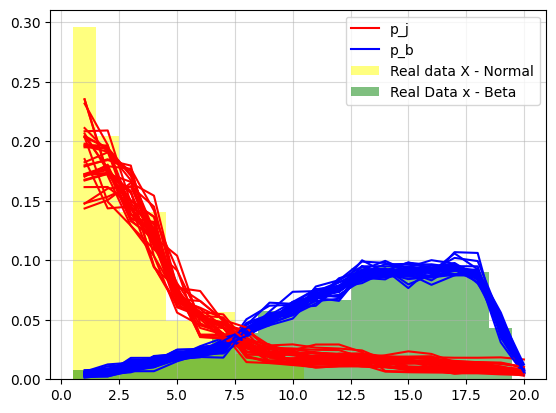

In [96]:
#Normalizing and plotting inferred distributions
for i in range(30):
    # Extract the p_j and p_b values for the current sample
    p_j_values = np.array([df_2d.iloc[i]['p_j.' + str(x)] for x in range(1, 21)])
    p_b_values = np.array([df_2d.iloc[i]['p_b.' + str(x)] for x in range(1, 21)])
    
    # Normalize the values
    p_j_values_normalized = p_j_values / p_j_values.sum()
    p_b_values_normalized = p_b_values / p_b_values.sum()
    
    # Plot the normalized curves
    if i == 0:
        plt.plot(range(1, 21), p_j_values_normalized, color='red', label='p_j')
        plt.plot(range(1, 21), p_b_values_normalized, color='blue', label='p_b')
    else:
        plt.plot(range(1, 21), p_j_values_normalized, color='red')
        plt.plot(range(1, 21), p_b_values_normalized, color='blue')

# Plot histograms for the real data X component
plt.hist(data_x_2_scaled[labels_2=='Normal'], bins=np.arange(1, m+1)-0.5, density=True, alpha=0.5, color='yellow', label='Real data X - Normal')
plt.hist(data_x_2_scaled[labels_2=='Beta'], bins=np.arange(1, m+1)-0.5, density=True, alpha=0.5, color='green', label='Real Data x - Beta')

#plt.plot(x1[:-1],y1[1:],ls='--',color='black')
#plt.plot(x2[:-1],y2[1:],ls='--',color='black')

plt.legend()
plt.grid(alpha=0.5)
plt.show()
